In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
def get_pretrained_microscopynet_url(encoder, encoder_weights):
    """Get the url to download the specified pretrained encoder.

    Args:
        encoder (str): pretrained encoder model name (e.g. resnet50)
        encoder_weights (str): pretraining dataset, either 'microscopynet' or 
            'imagenet-microscopynet' with the latter indicating the encoder
            was first pretrained on imagenet and then finetuned on microscopynet

    Returns:
        str: url to download the pretrained model
    """
    url_base = 'https://nasa-public-data.s3.amazonaws.com/microscopy_segmentation_models/'
    url_end = '_v1.0.pth.tar'
    return url_base + f'{encoder}_pretrained_{encoder_weights}' + url_end

In [4]:
import torch.utils.model_zoo as model_zoo
import torch

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)
url = get_pretrained_microscopynet_url('resnet50', 'microscopynet')
model.load_state_dict(model_zoo.load_url(url))
model.eval()  # <---- this is the MicroscopyNet model

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /itf-fi-ml/home/poyenyt/.cache/torch/hub/v0.10.0.zip
Downloading: "https://nasa-public-data.s3.amazonaws.com/microscopy_segmentation_models/resnet50_pretrained_microscopynet_v1.0.pth.tar" to /itf-fi-ml/home/poyenyt/.cache/torch/hub/checkpoints/resnet50_pretrained_microscopynet_v1.0.pth.tar
100%|██████████████████████████████████████████████████| 97.8M/97.8M [00:09<00:00, 11.0MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
from patchify import patchify, unpatchify
import numpy as np
from PIL import Image, ImageOps

def downsample_and_pad(img: "PIL.Image", 
                       patch_size, 
                       down_sampling:int
                      ) -> "PIL.Image":
    resized_img = img.resize((img.size[0]//down_sampling, img.size[1]//down_sampling))
    width, height = resized_img.size
    size_width = patch_size[0]*(width//patch_size[0]+1)
    size_height = patch_size[1]*(height//patch_size[1]+1)
    padded_img = ImageOps.pad(resized_img, size=(size_width, size_height))
    return padded_img

x = Image.fromarray(np.ones((1095,2061)))
y = downsample_and_pad(x, (256,256), 2)
y.size

(1280, 768)

In [225]:
wandb.finish()

epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
metric/mean_iou_cauliflower_FeO,▅▂▅▁▅▆▅▆▄▅▄▆▄▆▅▇▆▆▇▇▆▇▇▆▄▆▇▇█▇▇▇▇▇▇██▇▇█
metric/mean_iou_cauliflower_FeS,▆▁▅▁▆▅▆▅▄▆▆▆▆▇▆▆▇▆▆▆▇▇▇▇▆▇▆▇▇▇▇█▅▆▇█▇▇▆▇
metric/mean_iou_cauliflower_cauliflower,▅▁▅▁▃▄▄▅▅▄▅▅▄▅▆▆▅▆▆▆▆▇▅▇▇▇▇█▆▅▇▇██▇▇▇▅▇▅
metric/mean_iou_cauliflower_magnitite,▆▁▅▁▄▅▄▇▄▅▆▇▇█▄▇▇▆▆█▇█▇▇▇▇▇▇▇▆▆▇██▇▇████
train/iou,▅▅▅▁▃▅▇▅▅█▅▇█▅▇▇▇█▄█▄▆▅▇▆▆▇▇█▇▇▇▆█▇█▇█▇▇
train/loss,▅▅▅█▃▅▂▂▄▄▅▂▃▂▃▃▅▃▂▁▂▁▆▁▂▂▃▂▂▂▁▁▂▂▁▁▂▂▅▂
trainer/global_step,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▂▂▅▂▂▆▂▂▂▇▂▂▇▂▂█▂▂▂▂▂
val/epoch_val_iou,▆▁▅▁▄▅▅▆▄▅▆▆▆▆▆▇▇▆▇▇▇███▇▇█▇█▇▇█████████
val/epoch_val_loss,██▆█▆▇▆▅▃▅▃▃▅▃▃▂▂▃▃▃▁▂▂▁▂▂▂▂▂▁▂▁▁▂▁▂▁▁▁▂
val/val_iou_epoch,▆▁▅▁▄▅▅▆▄▅▆▆▆▆▆▇▇▆▇▇▇███▇▇█▇█▇▇█████████


In [167]:
from sav.utils.preprocess import make_binary_mask_dir

make_binary_mask_dir("data/cauliflower/cauliflower_structure/annotation")

data/cauliflower/cauliflower_structure/annotation/channel1_slice_151.tiff
save the binary mask to data/cauliflower/cauliflower_structure/annotation/channel1_slice_151.tiff
data/cauliflower/cauliflower_structure/annotation/channel1_slice_199.tiff
save the binary mask to data/cauliflower/cauliflower_structure/annotation/channel1_slice_199.tiff
data/cauliflower/cauliflower_structure/annotation/channel1_slice_600png.tiff
save the binary mask to data/cauliflower/cauliflower_structure/annotation/channel1_slice_600png.tiff
data/cauliflower/cauliflower_structure/annotation/channel1_slice_100.tiff
save the binary mask to data/cauliflower/cauliflower_structure/annotation/channel1_slice_100.tiff
data/cauliflower/cauliflower_structure/annotation/channel1_slice_800.tiff
save the binary mask to data/cauliflower/cauliflower_structure/annotation/channel1_slice_800.tiff
data/cauliflower/cauliflower_structure/annotation/channel1_slice_1000.tiff
save the binary mask to data/cauliflower/cauliflower_struct

In [18]:
import PIL.Image as Image
path = "data/cauliflower/FeS/annotation/channel1_slice_800.tiff"
Image.open(path)
# ImageOps.flip(Image.open(path)).save(path)

ValueError: Could not save to PNG for display

<PIL.TiffImagePlugin.TiffImageFile image mode=F size=2048x1536>

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import numpy as np

a = np.array(Image.open("data/apollo_70017/phase_3/image/0424.tiff"))
b = np.array(Image.open("data/apollo_70017/phase_3/annotation/0424.tiff"))

fig, axs = plt.subplots(1,1,figsize=(6,6),dpi=300)
plt.imshow(a, cmap='gray')
plt.imshow(b, cmap='cividis',alpha=0.1)

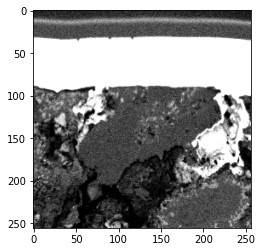

In [74]:
import torch
import torchvision.transforms.v2 as transforms
import PIL.Image as Image
import matplotlib.pyplot as plt

test_img = Image.open('test_data/cauliflower2/channel1_slice_510.tiff')
T = transforms.Compose([transforms.ToTensor(),
                        transforms.ScaleJitter((2048,1536),scale_range=(0.125,1)),
                        transforms.RandomCrop(size=(256,256),pad_if_needed=True),],
                        )
out_img = T(test_img).numpy().squeeze()
plt.imshow(out_img, cmap='gray')

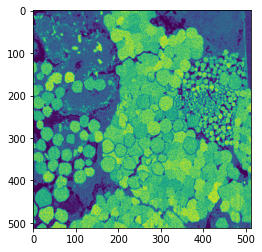

In [52]:
from skimage.filters import gaussian
import numpy as np

back_img = Image.open('test_data/cauliflower_magnetite_sup/image/300_x1500y600.tiff')
back_mask = Image.open('test_data/cauliflower_magnetite_sup/annotation/300_x1500y600.tiff')
test_img = Image.open('test_data/cauliflower_magnetite_sup/image/300_x750y700.tiff')
test_mask = Image.open('test_data/cauliflower_magnetite_sup/annotation/300_x750y700.tiff')
back_img, back_mask, test_img, test_mask = np.array(back_img), np.array(back_mask),np.array(test_img), np.array(test_mask)

def image_copy_paste(img, paste_img, alpha, blend=True, sigma=1):
    if alpha is not None:
        if blend:
            alpha = gaussian(alpha, sigma=sigma, preserve_range=True)

        img_dtype = img.dtype
        # alpha = alpha[..., None]
        img = paste_img * alpha + img * (1 - alpha)
        img = img.astype(img_dtype)
    return img

out_img = image_copy_paste(np.array(back_img), np.array(test_img), np.array(test_mask))
plt.imshow(out_img)

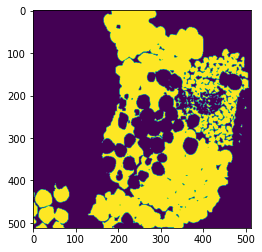

In [62]:
def mask_copy_paste(mask, paste_mask):
    if paste_mask is not None:
        #eliminate pixels that will be pasted over
        mask = np.logical_and(mask, np.logical_xor(mask, paste_mask)).astype(np.uint8)
    return mask

out_mask = mask_copy_paste(back_mask,test_mask)
plt.imshow(out_mask)

In [18]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks.progress import RichProgressBar
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from sav.datamodule import DatamoduleSAV
from sav.module.fs_segmenter import FewShotSegmenter
import wandb
wandb.login()

args = dict(# checkpoint
            seed=0, 
            num_epoch=200,
            checkpoint_path='checkpoints/20230411_256_copy_paste',
            model_name='Avgpool',
            version='0',
            precision_for_training=16,
    
            # for model
            backbone='vgg16', 
            optimizer='adam', 
            learning_rate=1e-4, 
            weight_decay=1e-5,
    
            # for datamodule
            datapath='data',
            nshot=3,
            nsamples=500,
            # img_sizes={'cauliflower':(2048,1536),
            #            'apollo':(1004,1024)},
            contrast=(0.5,1.5),
            rotation_degrees=90.0,
            scale=(0.25,1.0),
            crop_size=256,
            val_data_ratio=0.15,
            batch_size=5,
            n_cpu=4,
            )

# Set Logger
# logger = WandbLogger(save_dir="lightning_logs",
#                      project="slice-and-view_avgpool",)
                     # id='25wrvgh9', resume='must')

# Set checkpoints paths
checkpoint_callback = ModelCheckpoint(
                            save_top_k=20,
                            monitor="val/val_loss", # val/epoch_val_iou
                            # every_n_epochs=5,
                            mode="min",
                            dirpath=args['checkpoint_path'],
                            filename= args['model_name'] + "-{epoch:02d}",
                         )

/itf-fi-ml/home/poyenyt/.local/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/itf-fi-ml/home/poyenyt/.local/lib/python3.9/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedba

In [21]:
pl.seed_everything(args['seed'])

datamodule = DatamoduleSAV(datapath=args['datapath'], 
                           nshot=args['nshot'],
                           nsamples=args['nsamples'],
                           # img_sizes=args['img_sizes'],
                           contrast=args['contrast'],
                           rotation_degrees=args['rotation_degrees'],
                           scale=args['scale'],
                           crop_size=args['crop_size'],
                           val_data_ratio=args['val_data_ratio'],
                           batch_size=args['batch_size'],
                           n_cpu=args['n_cpu'])

model = FewShotSegmenter(backbone=args['backbone'], 
                         optimizer=args['optimizer'], 
                         learning_rate=args['learning_rate'],
                         weight_decay=args['weight_decay']
                        ).load_from_checkpoint('checkpoints/20230411_256_copy_paste/Avgpool-epoch=194.ckpt')

# cauli_apollo/checkpoints/cauli_apollo/last.ckpt
# checkpoints/20230411_256_copy_paste/Avgpool-epoch=194.ckpt

# trainer = pl.Trainer(max_epochs=args['num_epoch'], 
#                      callbacks=[RichProgressBar(),checkpoint_callback],
#                      logger=logger, 
#                      precision=args['precision_for_training'],
#                      accelerator='gpu', 
#                      devices=1,
#                      resume_from_checkpoint='checkpoints/20230411_256_copy_paste/Avgpool-epoch=121.ckpt')

# trainer.fit(model, datamodule)

Global seed set to 0
/itf-fi-ml/home/poyenyt/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/itf-fi-ml/home/poyenyt/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
from sav.utils.annotator import Annotator
from torchvision import transforms


annotator = Annotator(model=model,
                      # dataset=dataset,
                      # phase='data/cauliflower/magnitite',
                      # transform = transforms.Compose([transforms.ToTensor(),
                      #                                 transforms.Resize((256,256)),
                      #                                 transforms.Normalize(mean=[0.5],std=[0.5])]),
                      resize=(768,1024),
                      patch_width=256, 
                      patch_height=256,
                      margin=24,
                      batch_size=3)

# out = annotator(query_img_path = "test_data/cauliflower2/channel1_slice_510.tiff",
#                 support_imgs_dir = "test_data/cauliflower_magnetite_sup/image",
#                 support_annots_dir = "test_data/cauliflower_magnetite_sup/annotation" )
out = annotator(query_img_path = "test_data/cauliflower2/channel1_slice_900.tiff",
                support_imgs_dir = "test_data/cauliflower2_sup/image",
                support_annots_dir = "test_data/cauliflower2_sup/annotation")

/itf-fi-ml/home/poyenyt/.local/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(-0.5, 1023.5, 767.5, -0.5)

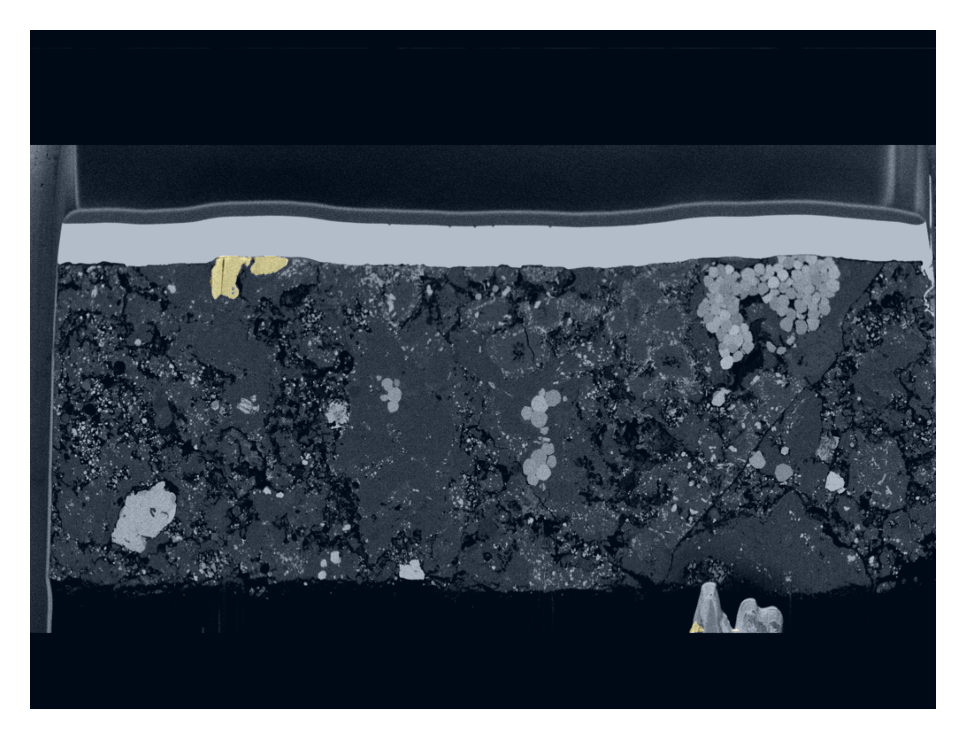

In [5]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1,1,figsize=(4,3),dpi=300)
axs.imshow(out['raw'],cmap='gray')
# axs.imshow(out['annot'], alpha=0.5, cmap='cividis')
axs.imshow(np.where(out['annot']>0.5,1,0), alpha=0.3, cmap='cividis')
axs.axis("off")

In [21]:
from sav.utils.visual import eval_model
from sav.datamodule import DatasetSAV

dataset = DatasetSAV(datapath='data', 
                     nshot=3,
                     nsamples=100,
                     rotation_degrees=90,
                     crop_size=768)

eval_model(module=model, 
               dataset=dataset, 
               phase_dir='data/cauliflower/magnitite',
               cmap_annot='cividis',
               cmap_annot_hat='cividis')

KeyboardInterrupt: 

In [45]:
out = annotator(query_img_path = "test_data/cauliflower2",
                support_imgs_dir = "test_data/cauliflower2_sup/image",
                support_annots_dir = "test_data/cauliflower2_sup/annotation",
                save_dir = "test_data/cauliflower2_mask")

Output()

In [8]:
annotator(query_img_path = "test_data/cauliflower2",
          support_imgs_dir = "test_data/cauliflower2_sup/image",
          support_annots_dir = "test_data/cauliflower2_sup/annotation",
          save_dir = "test_data/cauliflower2_mask")

Output()